# General data reader for AQUA 
## Using the accessor

AQUA also provides a special 'aqua' accessor to Xarray which allows to call most functions and methods of the reader
class as if they were methods of an Xarray DataArray or Dataset.

Reader methods like `reader.regrid()` or functions like `plot_single_map()` can now also be accessed by appending
the suffix `aqua`to a DataArray or Dataset, followed by the function of interest, like in `data.aqua.regrid()`

Here is an example. First we load some data

In [7]:
from aqua import Reader
reader = Reader(model="IFS", exp="control-1950-nemo-dev", source="monthly-1deg-2d", regrid="r200")
data = reader.retrieve()

Suppose now that we would like to plot the yearly mean of the first year of total cloud cover, regridded to resolution 'r200'.

Normally we would do this with AQUA as follows:

In [ ]:
from aqua import plot_single_map
tccr = reader.regrid(data.tcc)
tccrm = reader.timmean(tccr, freq="Y").isel(time=1)
plot_single_map(tccrm)

Using the accessor we con now do this in a more compact and elegant way, as follows:

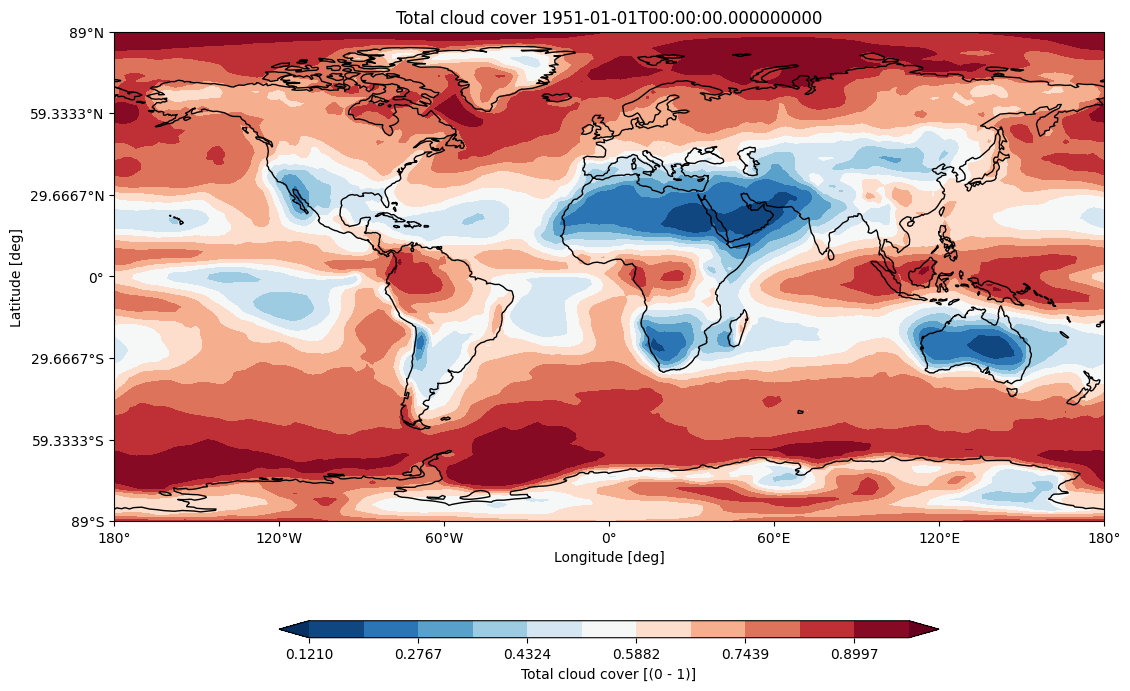

In [10]:
data.tcc.aqua.regrid().aqua.timmean(freq="Y").isel(time=1).aqua.plot_single_map()

The timeseries of the global mean of the data is directly

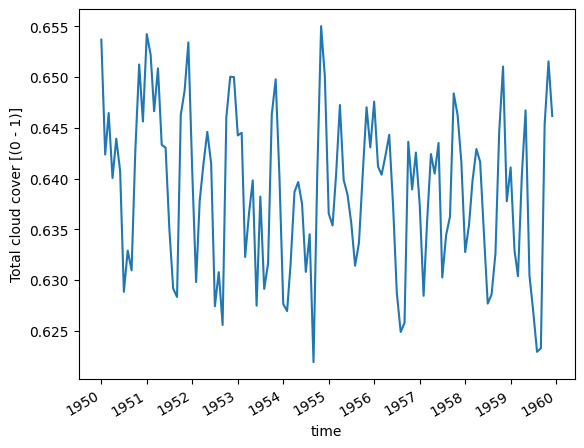

In [12]:
data.tcc.aqua.fldmean().plot()

The full list of functions and reader methods currently implemented for the accessor is:

Functions:
- plot_single_map()
- area_selection()

Reader methods:
- regrid()
- timmean()
- fldmean()
- vertinterp()
- stream()

### Use case with multiple reader instances

An important point is that the accessor always uses as a default the last Reader instance that was used.
The accessor extends Xarray functionality, but it does not define new objects, we are still working with regular Xarray Datasets or
DataArrays. 

Actually for Xarray objects obtained from reader methods, such as `retrieve()`, the resulting Dataset 'remembers' the correct reader instance, but this is not very robust: any operation that creates a new object, e.g. just using the `sel()` or `isel()` methods, will remove this 'memory' and the current default will be used instead. This may lead to unexpected results.

For this reason we recommend **not** to use the accessor if multiple reader instances are used, or to explicitly set the current default reader instance using the `set_default()` method of the Reader.

For example:

In [20]:
from aqua import Reader
reader1 = Reader(model="IFS", exp="control-1950-nemo-dev", source="monthly-1deg-2d", regrid="r100")
reader2 = Reader(model="IFS", exp="control-1950-nemo-dev", source="monthly-1deg-2d", regrid="r200")
data1 = reader1.retrieve()
data2 = reader2.retrieve()

data1r = data1.aqua.regrid()

This will work as expected because `data1` 'remembers' that `reader1` was used to create it.
It is enough to just create a new object to revert back to the current default. Since the last operation was with `data1` the default is now `reader1`. This sequence would not work as expected (they would both interpolate to 'r100'):

In [26]:
data1r = data1.isel(time=1).aqua.regrid()
data2r = data2.isel(time=1).aqua.regrid()

If we use the `set_default()` method of the Reader we can specify which reader instance to use in the following:

In [31]:
reader1.set_default()
data1r = data1.isel(time=1).aqua.regrid()
# ... do other things with the accessor using reader1 methods

reader2.set_default()
data2r = data2.isel(time=1).aqua.regrid()
data2rm = data2r.aqua.fldmean()
# ... do other things with the accessor reader2 methods


`set_default(reader)` is also a method of the accessor, so we could also do this (but the syntax above is probably cleaner):

In [ ]:
data1r = data1.isel(time=1).aqua.set_default(reader1).aqua.regrid()  # After the set_default() reader1 becomes the default
# ... do other things with the accessor using reader1 methods

data2r = data2.isel(time=1).aqua.set_default(reader2).aqua.regrid()  # After the set_default() reader2 becomes the default
data2rm = data2r.aqua.fldmean()
# ... do other things with the accessor reader2 methods
